In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch

/var/folders/b3/j4713tv9141907yd3mz1jn7w0000gn/T/ipykernel_66981/2208967272.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [9]:
import os
import zipfile

with zipfile.ZipFile("/Users/manisha/Downloads/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/Users/manisha/Downloads/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [10]:
main_dir = "/Users/manisha/Downloads/dogs-vs-cats"
train_dir = "/Users/manisha/Downloads/dogs-vs-cats/train"
path = os.path.join(main_dir,train_dir)

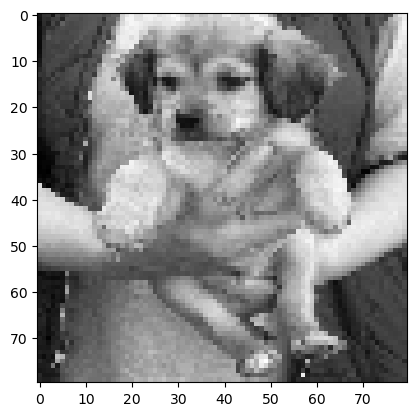

In [11]:
for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [12]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)

In [13]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)
X = X/255.0

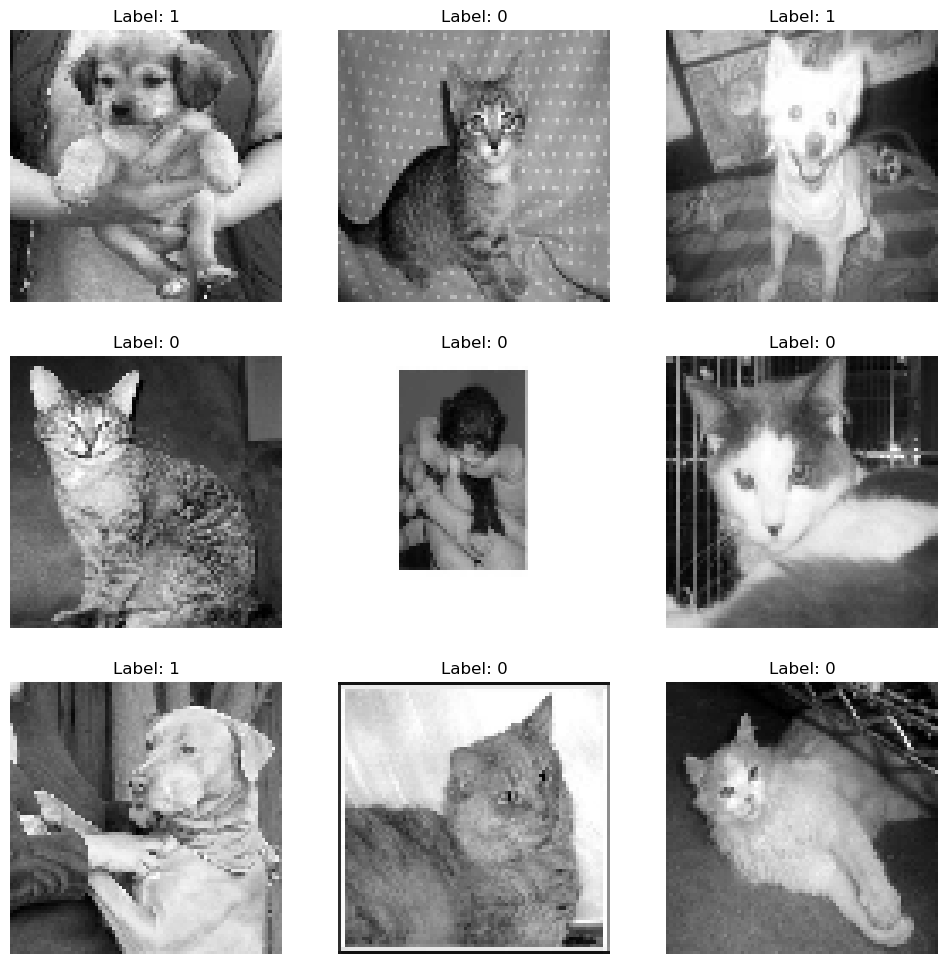

In [14]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i].reshape(80, 80), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()

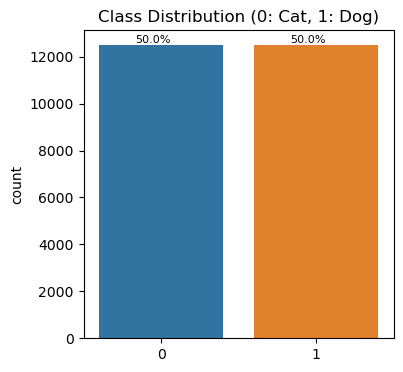

In [15]:
# Visualize class distribution with percentage values on top of the bars
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=y)
plt.title('Class Distribution (0: Cat, 1: Dog)')

# Add percentage values on top of the bars
total = len(y)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    d = p.get_x() + p.get_width() / 2 - 0.05
    z = p.get_height() + 0.1
    ax.text(d, z, percentage, ha='center', va='bottom', fontsize=8, color='black')

plt.show()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Define the Deep Learning Model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and connect Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Compile the model with optimizer and loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create augmented data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [20]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
# Train the model with augmented data and early stopping
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 [==============================] - 53s 84ms/step - loss: 0.6741 - accuracy: 0.5821 - val_loss: 0.6451 - val_accuracy: 0.6284
Epoch 2/10
625/625 [==============================] - 56s 90ms/step - loss: 0.6121 - accuracy: 0.6711 - val_loss: 0.5791 - val_accuracy: 0.6902
Epoch 3/10
625/625 [==============================] - 57s 91ms/step - loss: 0.5682 - accuracy: 0.7138 - val_loss: 0.5258 - val_accuracy: 0.7480
Epoch 4/10
625/625 [==============================] - 55s 89ms/step - loss: 0.5385 - accuracy: 0.7363 - val_loss: 0.5087 - val_accuracy: 0.7506
Epoch 5/10
625/625 [==============================] - 52s 84ms/step - loss: 0.5102 - accuracy: 0.7541 - val_loss: 0.4900 - val_accuracy: 0.7632
Epoch 6/10
625/625 [==============================] - 54s 87ms/step - loss: 0.4918 - accuracy: 0.7657 - val_loss: 0.4608 - val_accuracy: 0.7828
Epoch 7/10
625/625 [==============================] - 56s 90ms/step - loss: 0.4783 - accuracy: 0.7767 - val_loss: 0.4451 - val_accuracy:

In [22]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 4s 23ms/step - loss: 0.4189 - accuracy: 0.8038
Validation Loss: 0.418911337852478, Validation Accuracy: 0.8037999868392944


In [20]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 17s 22ms/step - loss: 0.4201 - accuracy: 0.8063
Train Loss: 0.4200582504272461, Train Accuracy: 0.8063200116157532


In [25]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

def preprocess(X):
      if isinstance(X, np.ndarray):
        # Already a NumPy array, just normalize
        X = X/255.0
        return X
      else:
        # Convert PIL image to NumPy array
        X = np.array(X)
        # Assuming RGB image, convert to grayscale 
        X = X[:, :, 0]
        # Reshape and normalize
        X = np.array(X).reshape(-1,80, 80, 1)
        X = X/255.0
        return X

img = load_img('/Users/manisha/Downloads/image.jpg', target_size=(80, 80))
U = preprocess(img)

preds = model.predict(U)

1/1 [==============================] - 0s 105ms/step


In [26]:
preds

array([[0.98342127]], dtype=float32)

Text(0.5, 1.0, 'Accuracy Curves')

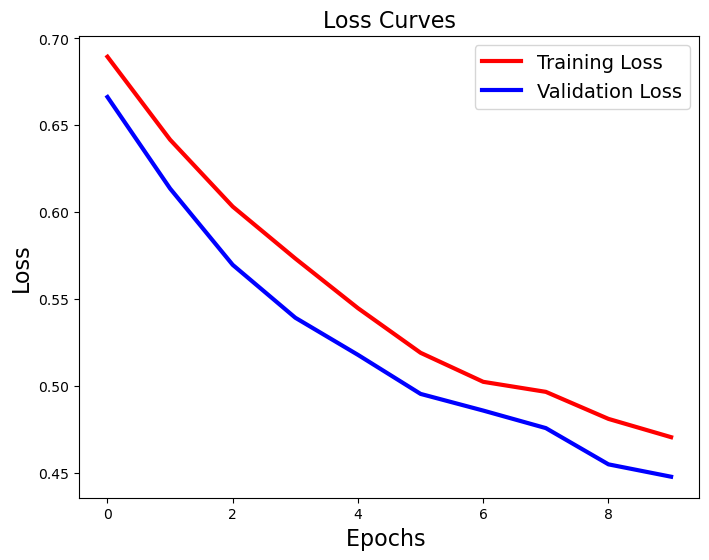

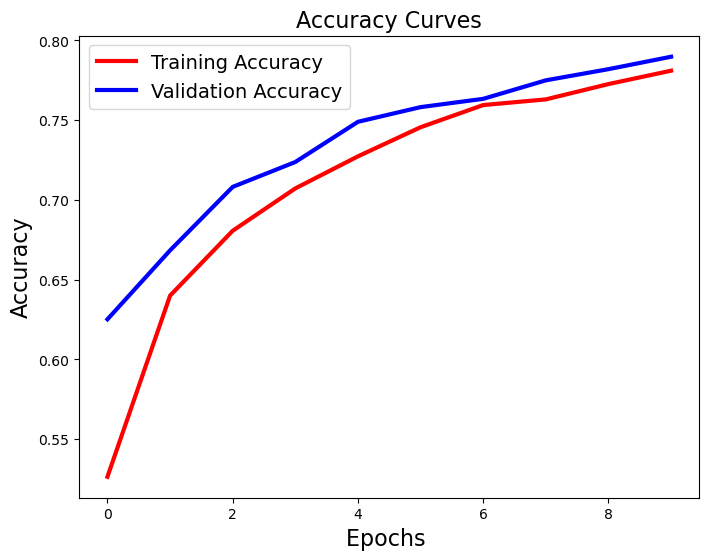

In [27]:
# Plot loss history
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


# Plot accuracy history
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [23]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=128, max_value=256, step=64), (3, 3), input_shape=(80, 80, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=128, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense1_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(hp.Int('dense2_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), # More rates can be added here
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials as needed
    directory='keras_tuner_dir',
    project_name='cats_vs_dogs'
)

tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Trial 2 Complete [01h 31m 51s]
val_accuracy: 0.7781999707221985

Best val_accuracy So Far: 0.8058000206947327
Total elapsed time: 22h 52m 04s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |256               |conv1_units
192               |128               |conv2_units
128               |128               |dense1_units
192               |128               |dense2_units
0.0001            |0.0001            |learning_rate



Epoch 1/10
625/625 [==============================] - 357s 571ms/step - loss: 0.6747 - accuracy: 0.5724 - val_loss: 0.6145 - val_accuracy: 0.6694
Epoch 2/10
472/625 [=====================>........] - ETA: 1:20 - loss: 0.6128 - accuracy: 0.6760

KeyboardInterrupt: 

In [25]:
tuner.results_summary()


Results summary
Results in keras_tuner_dir/cats_vs_dogs
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
conv1_units: 256
conv2_units: 128
dense1_units: 128
dense2_units: 128
learning_rate: 0.0001
Score: 0.8058000206947327

Trial 01 summary
Hyperparameters:
conv1_units: 192
conv2_units: 192
dense1_units: 256
dense2_units: 256
learning_rate: 0.001
Score: 0.7781999707221985

Trial 02 summary
Hyperparameters:
conv1_units: 128
conv2_units: 192
dense1_units: 128
dense2_units: 192
learning_rate: 0.0001


In [26]:
# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]

In [27]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 33s 209ms/step - loss: 0.4045 - accuracy: 0.8136
Validation Loss: 0.4045048952102661, Validation Accuracy: 0.8136000037193298


In [28]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 165s 211ms/step - loss: 0.3875 - accuracy: 0.8236
Train Loss: 0.38752999901771545, Train Accuracy: 0.8235599994659424


In [31]:
history = best_model.fit(
    train_generator,
    epochs=2,  # Adjust the number of additional epochs as needed
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)


Epoch 1/2
625/625 [==============================] - 543s 870ms/step - loss: 0.4228 - accuracy: 0.8097 - val_loss: 0.4065 - val_accuracy: 0.8156
Epoch 2/2
625/625 [==============================] - 547s 874ms/step - loss: 0.4121 - accuracy: 0.8162 - val_loss: 0.3981 - val_accuracy: 0.8148


In [32]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

157/157 [==============================] - 34s 219ms/step - loss: 0.4152 - accuracy: 0.8030
Validation Loss: 0.4152185618877411, Validation Accuracy: 0.8029999732971191


In [33]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

782/782 [==============================] - 171s 219ms/step - loss: 0.3959 - accuracy: 0.8150
Train Loss: 0.3959074318408966, Train Accuracy: 0.8150399923324585


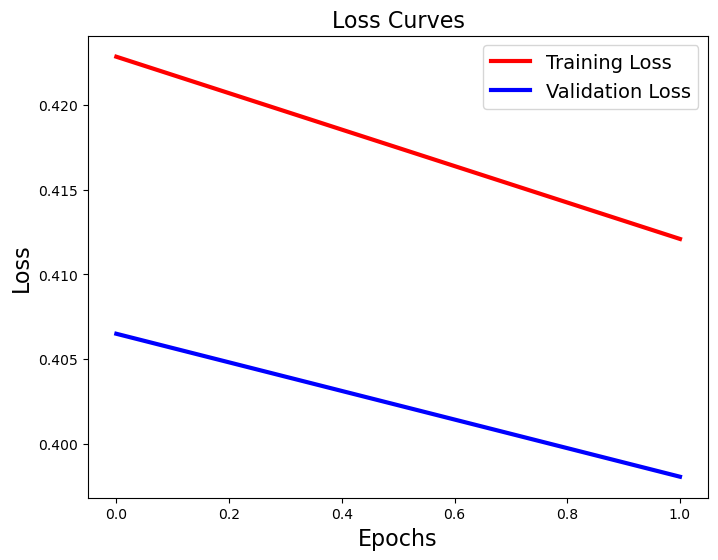

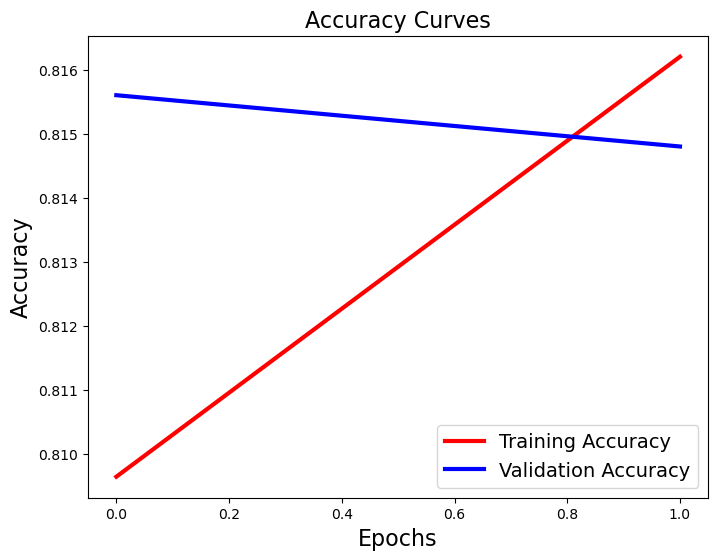

In [34]:
# Plot loss history
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

# Plot accuracy history
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [35]:
# Save the model for further use
best_model.save('dog_cat_classifier.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

tflite_model = converter.convert()


with open('dog_cat_classifier.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

/Users/manisha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/b3/j4713tv9141907yd3mz1jn7w0000gn/T/tmpj5kbi3m3/assets


INFO:tensorflow:Assets written to: /var/folders/b3/j4713tv9141907yd3mz1jn7w0000gn/T/tmpj5kbi3m3/assets
2023-12-20 22:11:16.969709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-20 22:11:16.969894: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-20 22:11:16.973448: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/b3/j4713tv9141907yd3mz1jn7w0000gn/T/tmpj5kbi3m3
2023-12-20 22:11:16.974815: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-20 22:11:16.974822: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/b3/j4713tv9141907yd3mz1jn7w0000gn/T/tmpj5kbi3m3
2023-12-20 22:11:16.979414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-20 22:11:16.981100: I tensorflow/cc/saved_model/load

In [37]:
# Apply the model to predict on test data
test_dir = "/Users/manisha/Downloads/dogs-vs-cats/test1"
test_path = os.path.join(main_dir,test_dir)
test_data = []
for p in os.listdir(test_path):
    img_array = cv2.imread(os.path.join(test_path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    test_data.append(new_img_array)

test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data/255.0

predictions = model.predict(test_data)

391/391 [==============================] - 9s 22ms/step


In [46]:
# Assuming predictions is a 2D array with values between 0 and 1
predictions = model.predict(test_data)

# Convert the predictions to labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Get the filenames from the test directory
test_filenames = os.listdir(test_path)

# Extract the IDs from the filenames
ids = [int(filename.split('.')[0]) for filename in test_filenames]

# Create a DataFrame with "id" and "label" columns
submission_df = pd.DataFrame({'id': ids, 'label': binary_predictions.flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Provide a link to download the CSV file
from IPython.display import FileLink

# Display a clickable link for downloading
FileLink('submission.csv')

391/391 [==============================] - 8s 21ms/step


/Users/manisha/submission.csv

In [40]:
print(submission_df)

         id  label
0      9733      0
1        63      1
2      6400      1
3       823      1
4      4217      0
...     ...    ...
12495  3561      0
12496  8434      1
12497  7707      0
12498  6419      0
12499  1376      1

[12500 rows x 2 columns]
